# ADAPTIVE ALERTING IN SIEM

### (1) Importing Data:

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler


In [2]:
kddcup_names = open("../datastore/kddcup.names").read().split('\n')
features = []
for feature in kddcup_names[1:]:
    features.append(feature.split(':')[0].strip())

features.append("connection_type")
features

['duration',
 'protocol_type',
 'service',
 'flag',
 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate',
 'connection_type']

In [3]:
data = pd.read_csv('../datastore/kddcup.data_10_percent', names=features, index_col=False, header=None)
data.head()
data.to_csv("../datastore/kddcup.data_10_percent_with_header.csv", index=False)

In [4]:
print('='*40)
print('Number of data points are:',data.shape[0])
print('='*40)
print('Number of features are:',data.shape[1])
print('='*40)
print('Some of the features are:',features[:10])
print('='*40)

Number of data points are: 494021
Number of features are: 42
Some of the features are: ['duration', 'protocol_type', 'service', 'flag', 'src_bytes', 'dst_bytes', 'land', 'wrong_fragment', 'urgent', 'hot']


In [5]:
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,connection_type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal.
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal.
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal.
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal.
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal.
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal.
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal.
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal.


In [6]:
output = data['connection_type'].values
labels = set(output)
print('The different type of output labels are:',labels)
print('='*125)
print('No. of different output labels are:', len(labels))

The different type of output labels are: {'ipsweep.', 'satan.', 'multihop.', 'ftp_write.', 'warezclient.', 'phf.', 'back.', 'land.', 'teardrop.', 'pod.', 'portsweep.', 'imap.', 'rootkit.', 'normal.', 'guess_passwd.', 'smurf.', 'loadmodule.', 'nmap.', 'warezmaster.', 'spy.', 'perl.', 'neptune.', 'buffer_overflow.'}
No. of different output labels are: 23


### (2) Data Cleaning

In [7]:
print('Null values in dataset are',len(data[data.isnull().any(1)]))

Null values in dataset are 0


In [8]:
data.connection_type.head()

0    normal.
1    normal.
2    normal.
3    normal.
4    normal.
Name: connection_type, dtype: object

Observed that there is an extra '.' in the 'connection_type' column after the connection type. For better visualization and interpretation, we remove the '.'.

In [9]:
data['connection_type'] = data['connection_type'].apply(lambda x : str(x)[:-1])
data.connection_type.head()

0    normal
1    normal
2    normal
3    normal
4    normal
Name: connection_type, dtype: object

Scaling all the numeric features between 0 and 1. Since we are given a detailed description of the data set features denoting which features are continuous and which are discrete along with the data types.

In [10]:
data.drop_duplicates(subset=features, keep='first', inplace=True)
data.shape

(145586, 42)

In [11]:
data.to_pickle('data.pkl')
data = pd.read_pickle('data.pkl')

### (3) Exploratory Data Analysis

Visualization of attack distribution over dataset

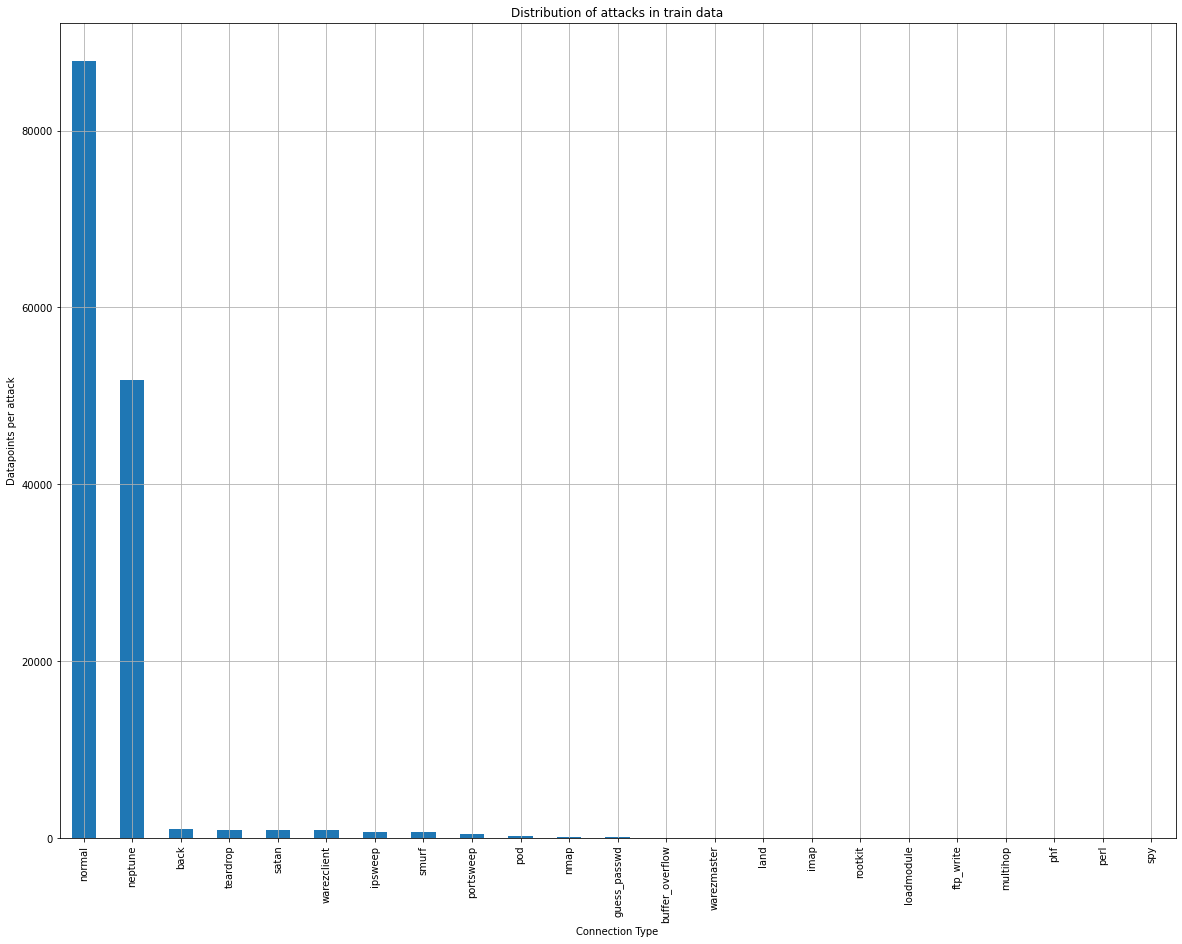

In [12]:
plt.figure(figsize=(20,15))
class_distribution = data['connection_type'].value_counts()
class_distribution.plot(kind='bar')
plt.xlabel('Connection Type')
plt.ylabel('Datapoints per attack')
plt.title('Distribution of attacks in train data')
plt.grid()
plt.show()

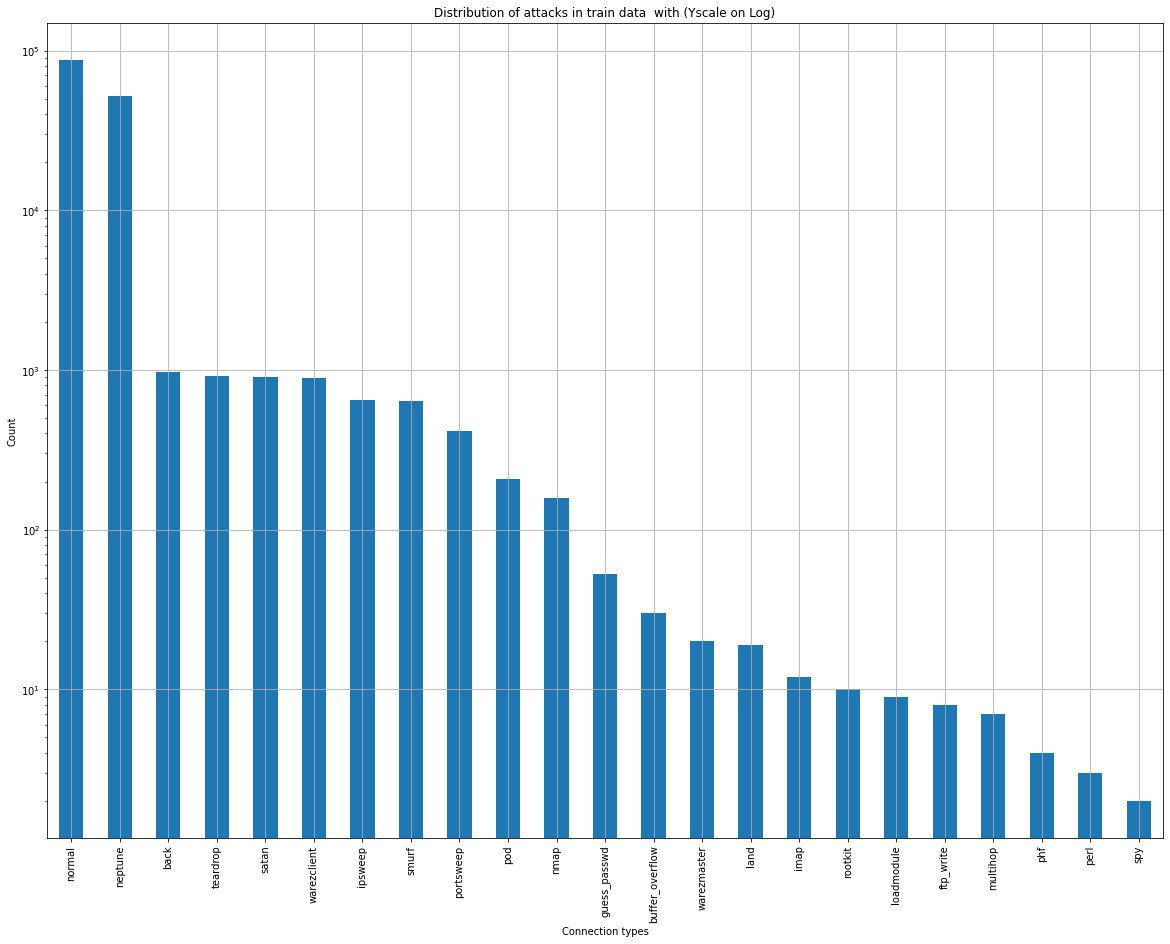

In [13]:
plt.figure(figsize=(20,15))
plt.yscale("log")
data["connection_type"].value_counts().plot(kind="bar")
plt.title('Distribution of attacks in train data  with (Yscale on Log)')
plt.ylabel("Count")
plt.xlabel("Connection types")
plt.grid()
plt.show()

In [14]:
sorted_y = np.argsort(-class_distribution.values)
for i in sorted_y:
    print('Number of data points in class', i+1,':', class_distribution.values[i], '(', np.round((class_distribution.values[i]/data.shape[0]*100), 3), '%)')

Number of data points in class 1 : 87832 ( 60.33 %)
Number of data points in class 2 : 51820 ( 35.594 %)
Number of data points in class 3 : 968 ( 0.665 %)
Number of data points in class 4 : 918 ( 0.631 %)
Number of data points in class 5 : 906 ( 0.622 %)
Number of data points in class 6 : 893 ( 0.613 %)
Number of data points in class 7 : 651 ( 0.447 %)
Number of data points in class 8 : 641 ( 0.44 %)
Number of data points in class 9 : 416 ( 0.286 %)
Number of data points in class 10 : 206 ( 0.141 %)
Number of data points in class 11 : 158 ( 0.109 %)
Number of data points in class 12 : 53 ( 0.036 %)
Number of data points in class 13 : 30 ( 0.021 %)
Number of data points in class 14 : 20 ( 0.014 %)
Number of data points in class 15 : 19 ( 0.013 %)
Number of data points in class 16 : 12 ( 0.008 %)
Number of data points in class 17 : 10 ( 0.007 %)
Number of data points in class 18 : 9 ( 0.006 %)
Number of data points in class 19 : 8 ( 0.005 %)
Number of data points in class 20 : 7 ( 0.005 

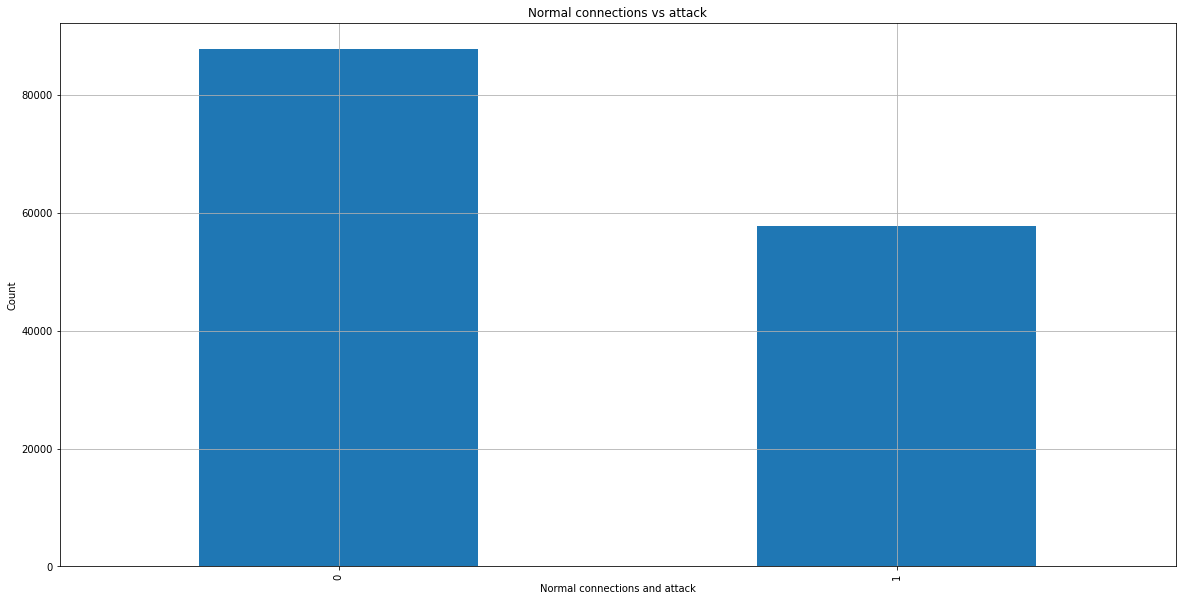

Percentage for  Normal Connection : 87832 ( 60.33 %)
Percentage for  Attack : 57754 ( 39.67 %)


In [15]:
data["label"] = data["connection_type"] != 'normal'
data["label"] = data["label"].apply(lambda x : int(x))
data.label.head()

plt.figure(figsize=(20,10))
plt.title("Normal connections vs attack")
connection_type_distribution = data['label'].value_counts()
connection_type_distribution.plot(kind='bar')
plt.ylabel("Count")
plt.xlabel("Normal connections and attack")
plt.grid()
plt.show()

sorted_y = np.argsort(-connection_type_distribution.values)
for i in sorted_y:
    print('Percentage for ', "Normal Connection" if i==0 else "Attack",':', connection_type_distribution.values[i], '(', np.round((connection_type_distribution.values[i]/data.shape[0]*100), 3), '%)')

In [16]:
DF_normal = data[data["label"] == 0]
DF_attacked = data[data["label"] == 1]

In [17]:
def plotHists(i, threshold = 0):
    plt.figure(figsize = [10,10])
    plt.subplot(2, 1, 1)
    plt.title('Histogram for '+i+': Normal connections')
    plt.yscale('log')
    plt.hist(DF_normal[DF_normal[i] > threshold][i], bins=300, color='green')
    plt.ylabel("Count")
    plt.xlabel(i+" Values")
    plt.subplot(2, 1, 2)
    plt.title('Histogram for '+i+': Attacked connections')
    plt.yscale('log')
    plt.hist(DF_attacked[DF_attacked[i] > threshold][i], bins = 300, color='red')
    plt.ylabel("Count")
    plt.xlabel(i+" Values")
    plt.show()

In [18]:
data["label"] = data["connection_type"] != 'normal'
data["label"] = data["label"].apply(lambda x : int(x))
data.label.head()

0    0
1    0
2    0
3    0
4    0
Name: label, dtype: int64

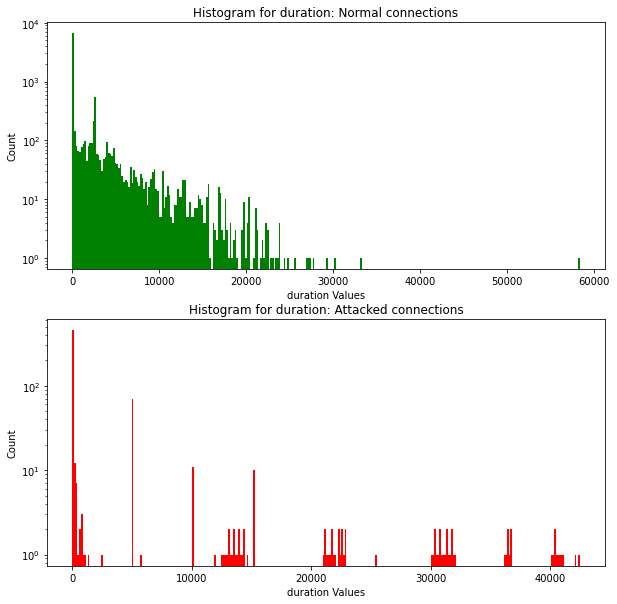

In [19]:
plotHists("duration")

From observation, the duration is concentrated towards smaller values in normal connections. Even though the duration values for attacks are spread over the entire range of values, we can conclude that if a connection's duration is more than 0.5, it might probably be an attack

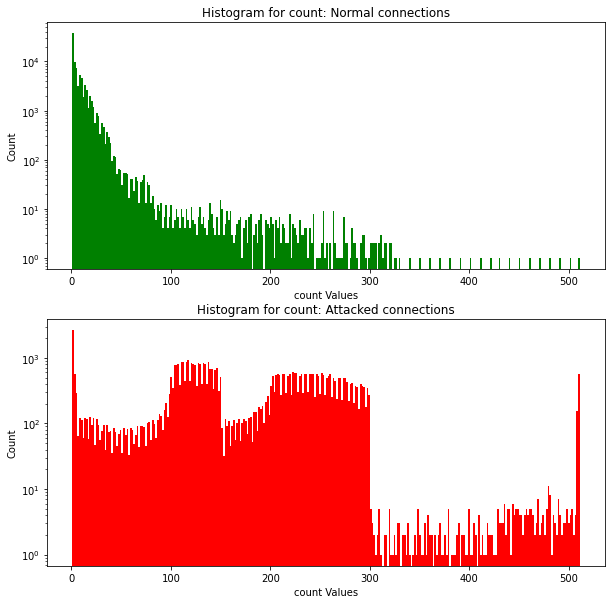

In [20]:
plotHists("count")

Frequency of connections to the same host is concentrated at smaller values for normal connections. However, for attacks, there is a surge between values 0.2 and 0.6 which could denote an attack.

### Univariate Analysis and Bivariate Analysis using pairplot

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19, 20, 21, 22]),
 <a list of 23 Text major ticklabel objects>)

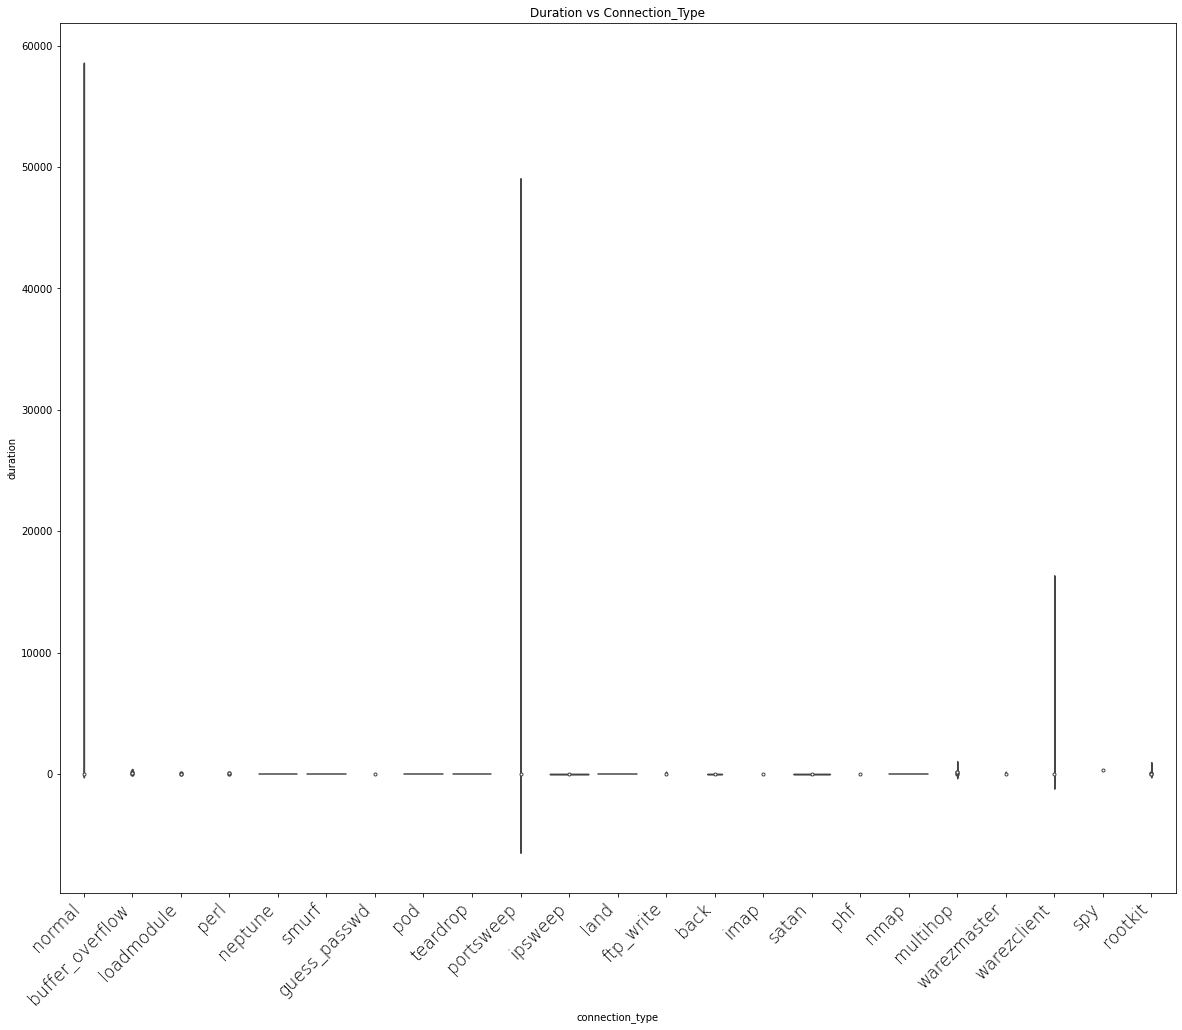

In [21]:
import seaborn as sns
plt.figure(figsize=(20,16))
plt.title('Duration vs Connection_Type')
sns.set(style="whitegrid")
ax = sns.violinplot(x="connection_type", y="duration", data=data, fliersize=None)
plt.xticks(
    rotation=45, 
    horizontalalignment='right',
    fontweight='light',
    fontsize='x-large'  
)

In [22]:
def pairplot(data, label, features=[]):
    '''
    This function creates pairplot taking 4 features from our dataset as default parameters along with the output variable
    '''
    sns.pairplot(data, hue=label, height=4, diag_kind='hist',   vars=features, plot_kws={'alpha':0.6, 's':80, 'edgecolor':'k'})

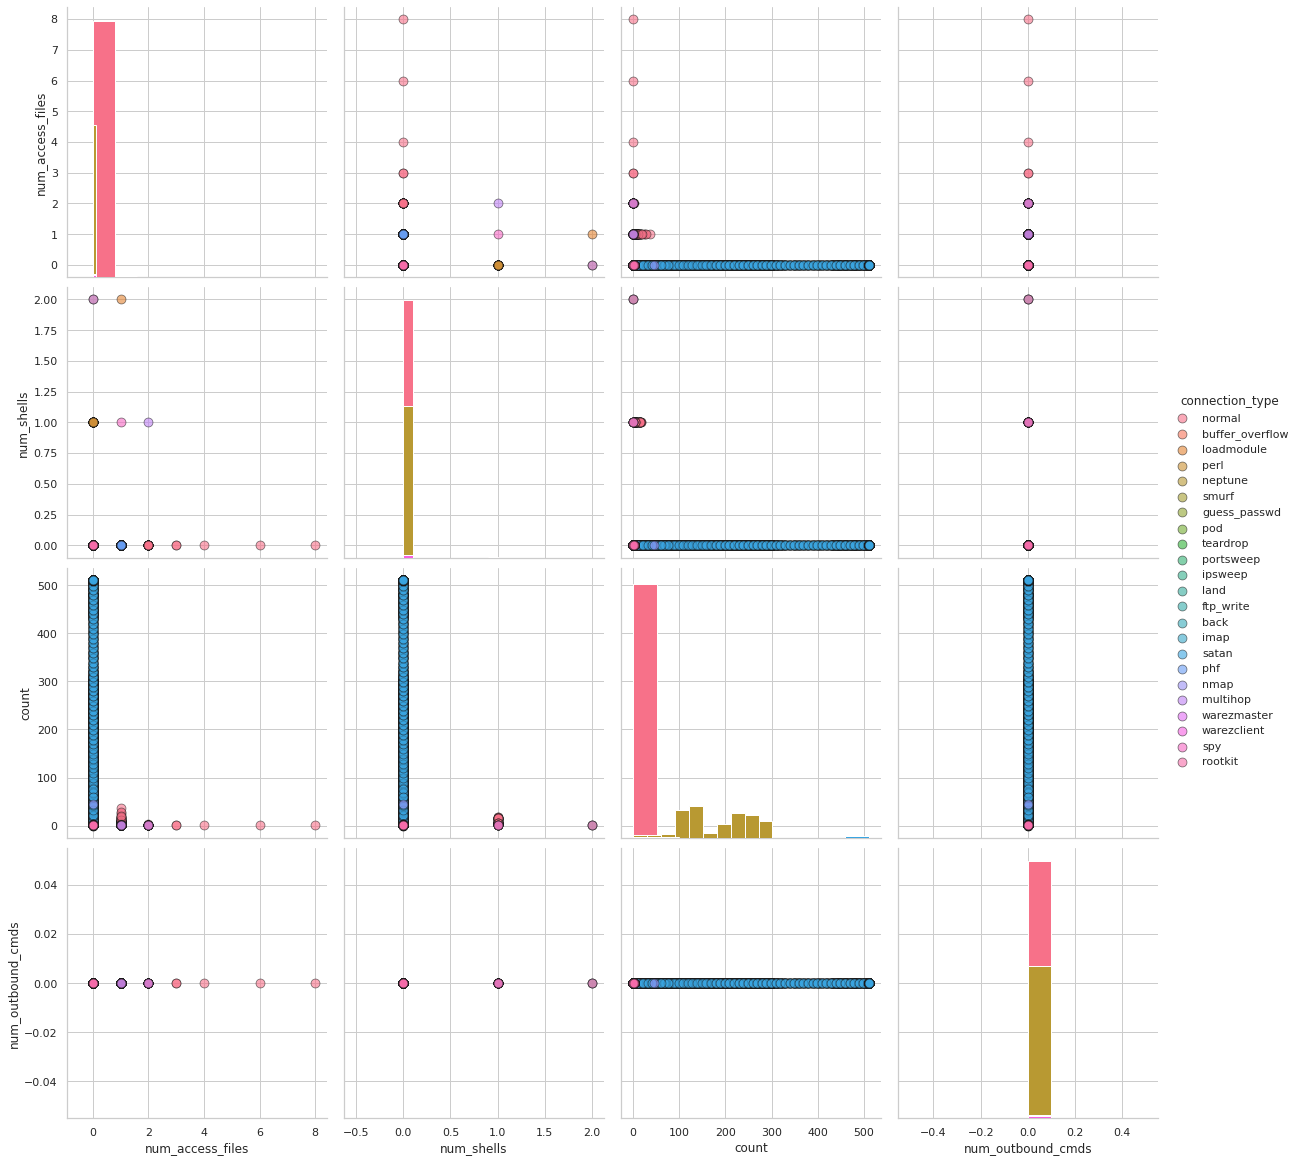

In [23]:
pairplot(data, "connection_type", features=[ "num_access_files", "num_shells","count" , "num_outbound_cmds"])

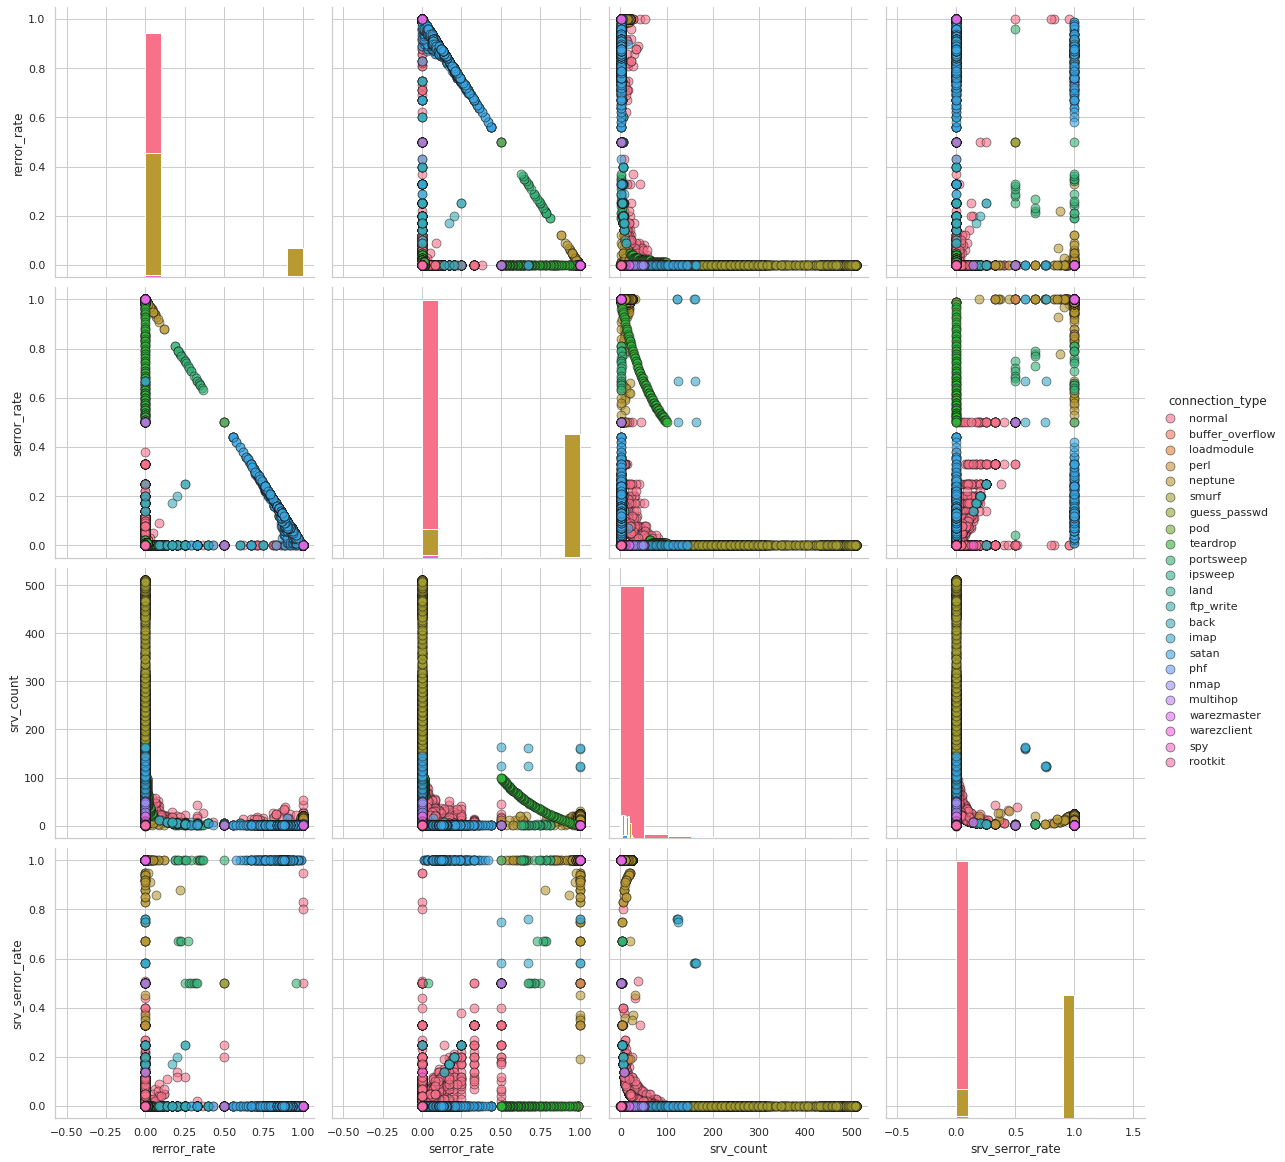

In [24]:
pairplot(data, "connection_type", features=[ "rerror_rate", "serror_rate","srv_count", "srv_serror_rate"])

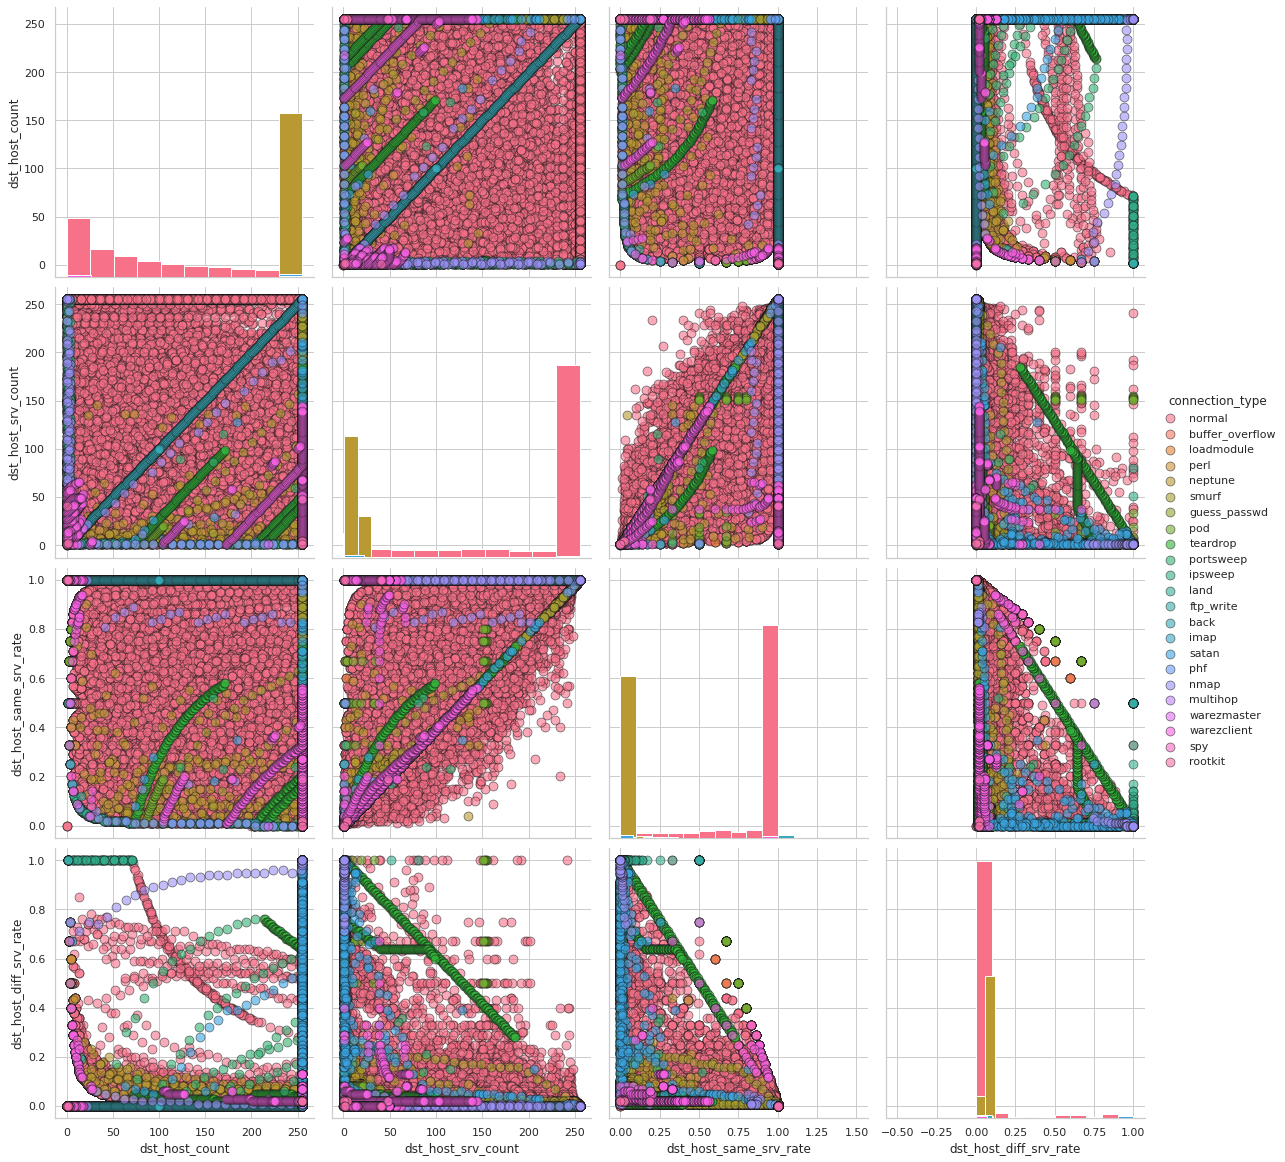

In [25]:
pairplot(data, 'connection_type', features=['dst_host_count','dst_host_srv_count','dst_host_same_srv_rate','dst_host_diff_srv_rate'])

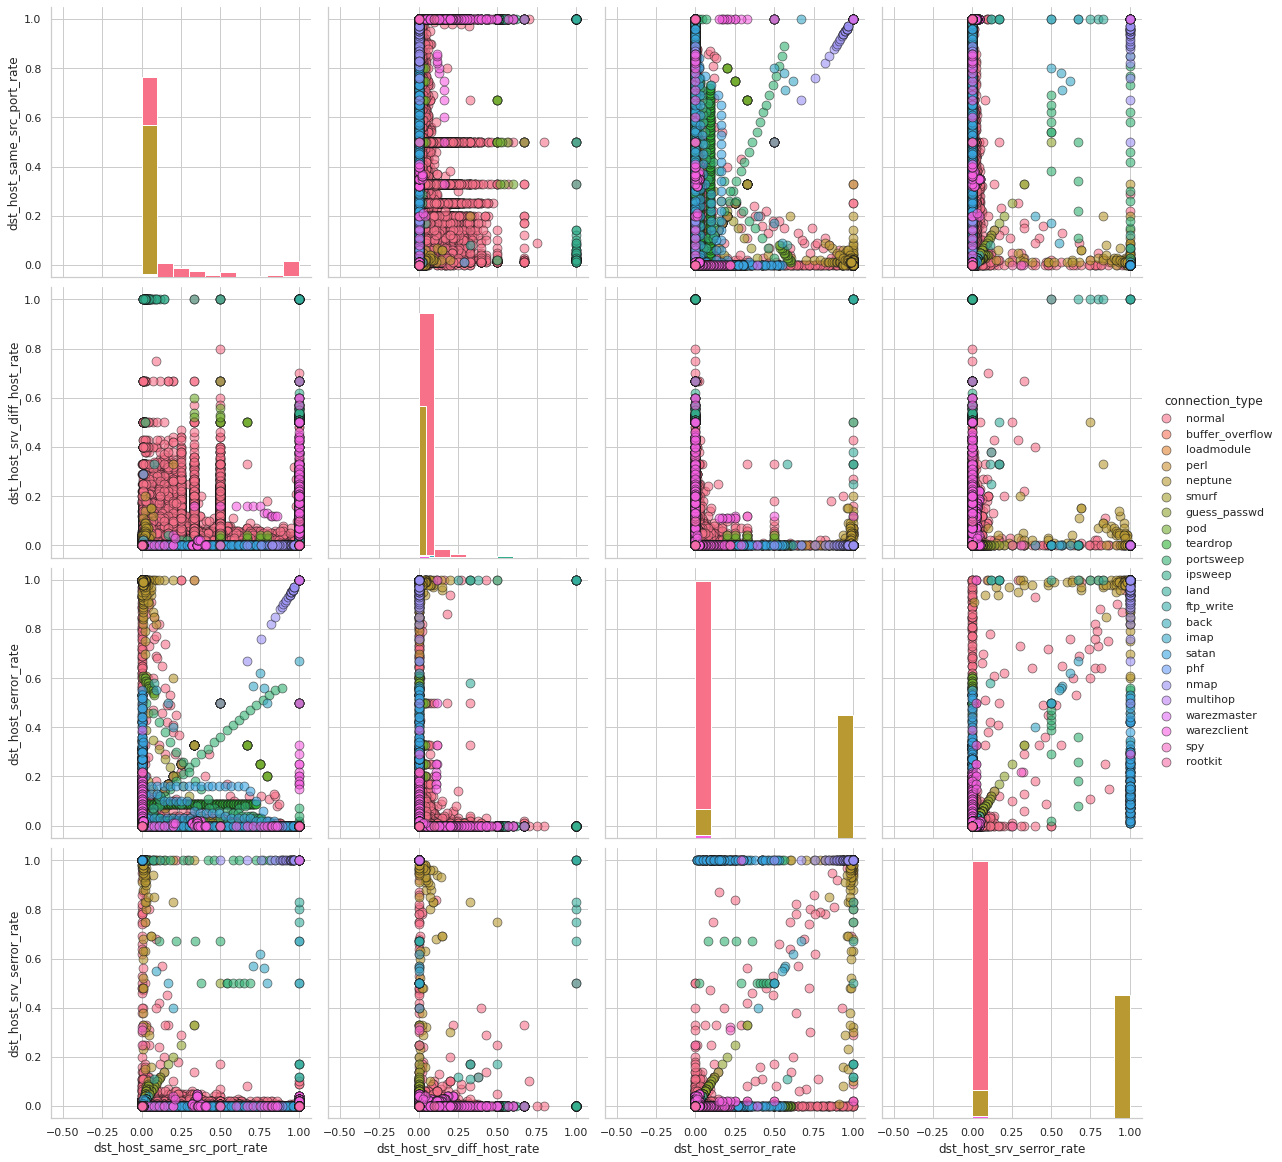

In [26]:
pairplot(data, 'connection_type', features=['dst_host_same_src_port_rate','dst_host_srv_diff_host_rate','dst_host_serror_rate','dst_host_srv_serror_rate'])

#### Observation


No linear separability but almost linear separability between the different output categories.


### TSNE for Bivariate Analysis ( t-Distributed Stochastic Neighbor Embedding)

In [27]:
from datetime import datetime
import joblib

data = data.drop('label', axis=1)
df = data.drop(['connection_type','protocol_type', 'service', 'flag'], axis=1)
Y = data['connection_type'].values

In [28]:
from sklearn.manifold import TSNE

def tsne_func(data, label, no_components, perplexity_value, n_iter_value):
    '''
    This function applies TSNE on the original dataset with  no_components, perplexity_value, n_iter_value as the TSNE parameters 
    and transforms the original dataset into TSNE transformed feature space with the tsne dataset containing number of features 
    equal to the value specified for no_components and also plots the scatter plot of the transformed data points along with 
    their class label 
    '''
    start = datetime.now()
    print('TSNE with perplexity={} and no. of iterations={}'.format(perplexity_value, n_iter_value))
    tsne = TSNE(n_components=no_components, perplexity=perplexity_value, n_iter=n_iter_value)
    tsne_df1 = tsne.fit_transform(data)
    print(tsne_df1.shape)
    tsne_df1 = np.vstack((tsne_df1.T, Y)).T
    tsne_data1 = pd.DataFrame(data=tsne_df1, columns=['feature1', 'feature2', 'Output'])
    sns.FacetGrid(tsne_data1, hue='Output', height=6).map(plt.scatter, 'feature1', 'feature2').add_legend()
    print('Duration:',datetime.now()-start)
    plt.show()


In [29]:
# tsne_func(df, "connection_type", no_components=2, perplexity_value =100, n_iter_value=500)

In [30]:
# tsne_func(df, "connection_type", no_components=2, perplexity_value =50, n_iter_value=1000)

 ### (4) Applying Machine Learning Models:

In [31]:
data

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate,connection_type
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,1.0,0.0,0.11,0.00,0.00,0.00,0.0,0.0,normal
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,1.0,0.0,0.05,0.00,0.00,0.00,0.0,0.0,normal
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,1.0,0.0,0.03,0.00,0.00,0.00,0.0,0.0,normal
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,1.0,0.0,0.02,0.00,0.00,0.00,0.0,0.0,normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
494016,0,tcp,http,SF,310,1881,0,0,0,0,...,255,1.0,0.0,0.01,0.05,0.00,0.01,0.0,0.0,normal
494017,0,tcp,http,SF,282,2286,0,0,0,0,...,255,1.0,0.0,0.17,0.05,0.00,0.01,0.0,0.0,normal
494018,0,tcp,http,SF,203,1200,0,0,0,0,...,255,1.0,0.0,0.06,0.05,0.06,0.01,0.0,0.0,normal
494019,0,tcp,http,SF,291,1200,0,0,0,0,...,255,1.0,0.0,0.04,0.05,0.04,0.01,0.0,0.0,normal


In [32]:
data.shape

(145586, 42)

### Feature Engineering

In [33]:
features=['duration', 'src_bytes',
 'dst_bytes',
 'land',
 'wrong_fragment',
 'urgent',
 'hot',
 'num_failed_logins',
 'logged_in',
 'num_compromised',
 'root_shell',
 'su_attempted',
 'num_root',
 'num_file_creations',
 'num_shells',
 'num_access_files',
 'num_outbound_cmds',
 'is_host_login',
 'is_guest_login',
 'count',
 'srv_count',
 'serror_rate',
 'srv_serror_rate',
 'rerror_rate',
 'srv_rerror_rate',
 'same_srv_rate',
 'diff_srv_rate',
 'srv_diff_host_rate',
 'dst_host_count',
 'dst_host_srv_count',
 'dst_host_same_srv_rate',
 'dst_host_diff_srv_rate',
 'dst_host_same_src_port_rate',
 'dst_host_srv_diff_host_rate',
 'dst_host_serror_rate',
 'dst_host_srv_serror_rate',
 'dst_host_rerror_rate',
 'dst_host_srv_rerror_rate']

In [34]:
y=Y
X = data.drop('connection_type', axis=1)

In [35]:
X.shape

(145586, 41)

### Vectorizing Categorical features using one-hot encoding

Some categorical features in our dataset are:- 'protocol_type', 'service', and 'flag

In [36]:
X.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,http,SF,181,5450,0,0,0,0,...,9,9,1.0,0.0,0.11,0.0,0.0,0.0,0.0,0.0
1,0,tcp,http,SF,239,486,0,0,0,0,...,19,19,1.0,0.0,0.05,0.0,0.0,0.0,0.0,0.0
2,0,tcp,http,SF,235,1337,0,0,0,0,...,29,29,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
3,0,tcp,http,SF,219,1337,0,0,0,0,...,39,39,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,tcp,http,SF,217,2032,0,0,0,0,...,49,49,1.0,0.0,0.02,0.0,0.0,0.0,0.0,0.0


In [37]:
def one_hot_encoder(data, features):
    """
    one hot encoding text values to dummy variables

    :param data:
    :param feature:
    :return:
    """
    for feature in features:
        dummies = pd.get_dummies(data[feature])
        for x in dummies.columns:
            dummy_feature = f"{feature}-{x}"
            data[dummy_feature] = dummies[x]
        data.drop(feature, axis=1, inplace=True)

In [38]:
categorical_features = ['protocol_type', 'service', 'flag', 'land','logged_in','is_host_login','is_guest_login']
                        
one_hot_encoder(X, categorical_features)

### Encoding Non Categorical features

Categorical features in our dataset are:- 'protocol_type', 'service', and 'flag

In [39]:
def zscore_numeric_encoder(data, features, mean=None, sd=None):
    """
    Encode numerical columns as z-scores
    
    :param data:
    :param feature:
    :param mean:
    :param sd:
    :return:
    """
    for feature in features:
        if mean is None:
            mean = data[feature].mean()

        if sd is None:
            sd = data[feature].std()

        data[feature] = (data[feature] - mean) / sd
        


In [40]:
non_categorical_features = ['duration', 'src_bytes', 'dst_bytes', 'wrong_fragment', 'urgent', 
                 'hot', 'num_failed_logins', 'num_compromised', 'root_shell', 'su_attempted',
                 'num_root', 'num_file_creations', 'num_shells', 'num_access_files', 'num_outbound_cmds', 
                 'count', 'srv_count', 'serror_rate', 'srv_serror_rate', 'rerror_rate', 'srv_rerror_rate', 
                 'same_srv_rate', 'diff_srv_rate', 'srv_diff_host_rate', 'dst_host_count', 'dst_host_srv_count',
                 'dst_host_same_srv_rate', 'dst_host_diff_srv_rate', 'dst_host_same_src_port_rate', 'dst_host_srv_diff_host_rate',
                 'dst_host_serror_rate', 'dst_host_srv_serror_rate', 'dst_host_rerror_rate', 'dst_host_srv_rerror_rate'
                 ]


zscore_numeric_encoder(X,non_categorical_features)

In [41]:
X.head()

,duration,src_bytes,dst_bytes,wrong_fragment,urgent,hot,num_failed_logins,num_compromised,root_shell,su_attempted,...,flag-S3,flag-SF,flag-SH,land-0,land-1,logged_in-0,logged_in-1,is_host_login-0,is_guest_login-0,is_guest_login-1
0,-0.10785,0.040007,4.344193,-0.10785,-0.10785,-0.10785,-0.10785,-0.10785,-0.10785,-0.10785,...,0,1,0,1,0,0,1,1,1,0
1,-0.10785,0.087387,0.289158,-0.10785,-0.10785,-0.10785,-0.10785,-0.10785,-0.10785,-0.10785,...,0,1,0,1,0,0,1,1,1,0
2,-0.10785,0.084119,0.984330,-0.10785,-0.10785,-0.10785,-0.10785,-0.10785,-0.10785,-0.10785,...,0,1,0,1,0,0,1,1,1,0
3,-0.10785,0.071049,0.984330,-0.10785,-0.10785,-0.10785,-0.10785,-0.10785,-0.10785,-0.10785,...,0,1,0,1,0,0,1,1,1,0
4,-0.10785,0.069415,1.552068,-0.10785,-0.10785,-0.10785,-0.10785,-0.10785,-0.10785,-0.10785,...,0,1,0,1,0,0,1,1,1,0


In [42]:
X= X.rename_axis('ID').values

In [43]:
X_1 =X

In [44]:
import datetime as dt
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score, precision_score, recall_score, f1_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV

In [45]:
def confusion_matrix_func(Y_test, y_test_pred):
    '''
    This function plots the confusion matrix heatmap using the actual and predicted values.
    '''
    C = confusion_matrix(Y_test, y_test_pred)
    cm_df = pd.DataFrame(C)
    labels = ['back', 'butter_overflow', 'loadmodule', 'guess_passwd', 'imap', 'ipsweep', 'warezmaster', 'rootkit', 
              'multihop', 'neptune', 'nmap', 'normal', 'phf', 'perl', 'pod', 'portsweep', 'ftp_write', 'satan', 'smurf',
              'teardrop', 'warezclient', 'land']
    plt.figure(figsize=(20,15))
    sns.set(font_scale=1.4)
    sns.heatmap(cm_df, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    
    plt.show()

In [46]:
def model(model_name, X_train, Y_train, X_test, Y_test):
    
    '''
    This function computes the performance scores on the train and test data.
    '''
    
    print('Fitting the model and prediction on train data:')
    start = dt.datetime.now()
    model_name.fit(X_train, Y_train)
    y_tr_pred = model_name.predict(X_train)
    print('Completed')
    print('Time taken:',dt.datetime.now()-start)
    print('='*50)
    
    results_tr = dict()
    y_tr_pred = model_name.predict(X_train)    
    results_tr['precision'] = precision_score(Y_train, y_tr_pred, average='weighted')
    results_tr['recall'] = recall_score(Y_train, y_tr_pred, average='weighted')
    results_tr['f1_score'] = f1_score(Y_train, y_tr_pred, average='weighted')
    
    results_test = dict()
    print('Prediction on test data:')
    start = dt.datetime.now()
    y_test_pred = model_name.predict(X_test)
    print('Completed')
    print('Time taken:',dt.datetime.now()-start)
    print('='*50)
    
    print('Performance metrics:')
    print('='*50)
    print('Confusion Matrix is:')
    confusion_matrix_func(Y_test, y_test_pred)
    print('='*50)
    results_test['precision'] = precision_score(Y_test, y_test_pred, average='weighted')
    print('Precision score is:')
    print(precision_score(Y_test, y_test_pred, average='weighted'))
    print('='*50)
    results_test['recall'] = recall_score(Y_test, y_test_pred, average='weighted')
    print('Recall score is:')
    print(recall_score(Y_test, y_test_pred, average='weighted'))
    print('='*50)
    results_test['f1_score'] = f1_score(Y_test, y_test_pred, average='weighted')
    print('F1-score is:')
    print(f1_score(Y_test, y_test_pred, average='weighted'))
    # add the trained  model to the results
    results_test['model'] = model
    
    return results_tr, results_test

###  Data Split

In [47]:
from sklearn.model_selection import train_test_split

X_train_1, X_test_1, y_train, y_test = train_test_split(X_1, Y, test_size=0.3, random_state=42)

#### Gaussian Naive Bayes

In [48]:
hyperparameter = {'var_smoothing':[10**x for x in range(-9,3)]}

from sklearn.naive_bayes import GaussianNB
nb = GaussianNB()
nb_grid = GridSearchCV(nb, param_grid=hyperparameter, cv=5, verbose=1, n_jobs=-1)

Fitting the model and prediction on train data:
Fitting 5 folds for each of 12 candidates, totalling 60 fits


/root/Projects/Python/AdaptiveSIEMAlerting/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done  60 out of  60 | elapsed:   38.1s finished


Completed
Time taken: 0:00:42.969882
Prediction on test data:
Completed
Time taken: 0:00:02.152308
Performance metrics:
Confusion Matrix is:


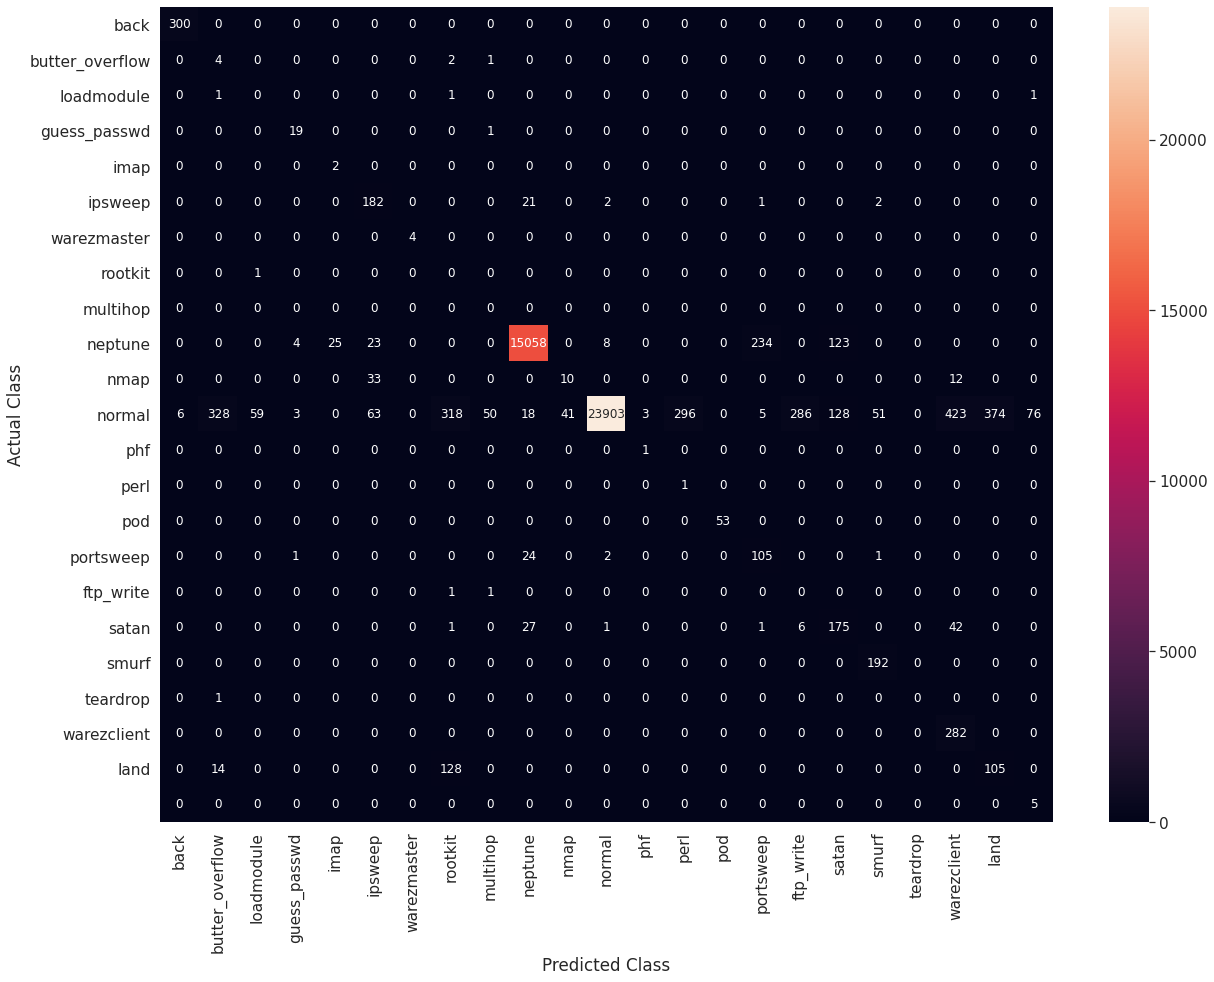

/root/Projects/Python/AdaptiveSIEMAlerting/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision score is:
0.9789194530468807


/root/Projects/Python/AdaptiveSIEMAlerting/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall score is:
0.9250160271087096
F1-score is:
0.948526570488395


({'precision': 0.9782578165860111,
  'recall': 0.9248356392895692,
  'f1_score': 0.9480803615316155},
 {'precision': 0.9789194530468807,
  'recall': 0.9250160271087096,
  'f1_score': 0.948526570488395,
  'model': <function __main__.model(model_name, X_train, Y_train, X_test, Y_test)>})

In [49]:
model(nb_grid, X_train_1, y_train, X_test_1, y_test)

### Observation


- Gaussian Naive Bayes Classifier was able to classify points with a high f1 score of 0.948, we can use more advanced Non-linear and linear classifiers ahead and we will try to classify the Normal and Attack connections with a higher f1-score.

- As the train and test scores are almost similar and high, we can say that the model is "NEITHER OVERFITTING NOR UNDERFITTING".

#### Logistic Regression

In [50]:
hyperparameter = {'alpha':[0.001, 0.01, 0.1, 1, 10, 20, 30], 'penalty':['l1', 'l2']}
from sklearn.linear_model import SGDClassifier
lr = SGDClassifier(loss='log')
lr_grid = GridSearchCV(lr, param_grid=hyperparameter, cv=5, verbose=1, n_jobs=-1)

Fitting the model and prediction on train data:
Fitting 5 folds for each of 14 candidates, totalling 70 fits


/root/Projects/Python/AdaptiveSIEMAlerting/venv/lib/python3.8/site-packages/sklearn/model_selection/_split.py:670: UserWarning: The least populated class in y has only 1 members, which is less than n_splits=5.
  warnings.warn(("The least populated class in y has only %d"
[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 11.7min
[Parallel(n_jobs=-1)]: Done  70 out of  70 | elapsed: 17.8min finished


Completed
Time taken: 0:18:09.005682


/root/Projects/Python/AdaptiveSIEMAlerting/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Prediction on test data:
Completed
Time taken: 0:00:00.039727
Performance metrics:
Confusion Matrix is:


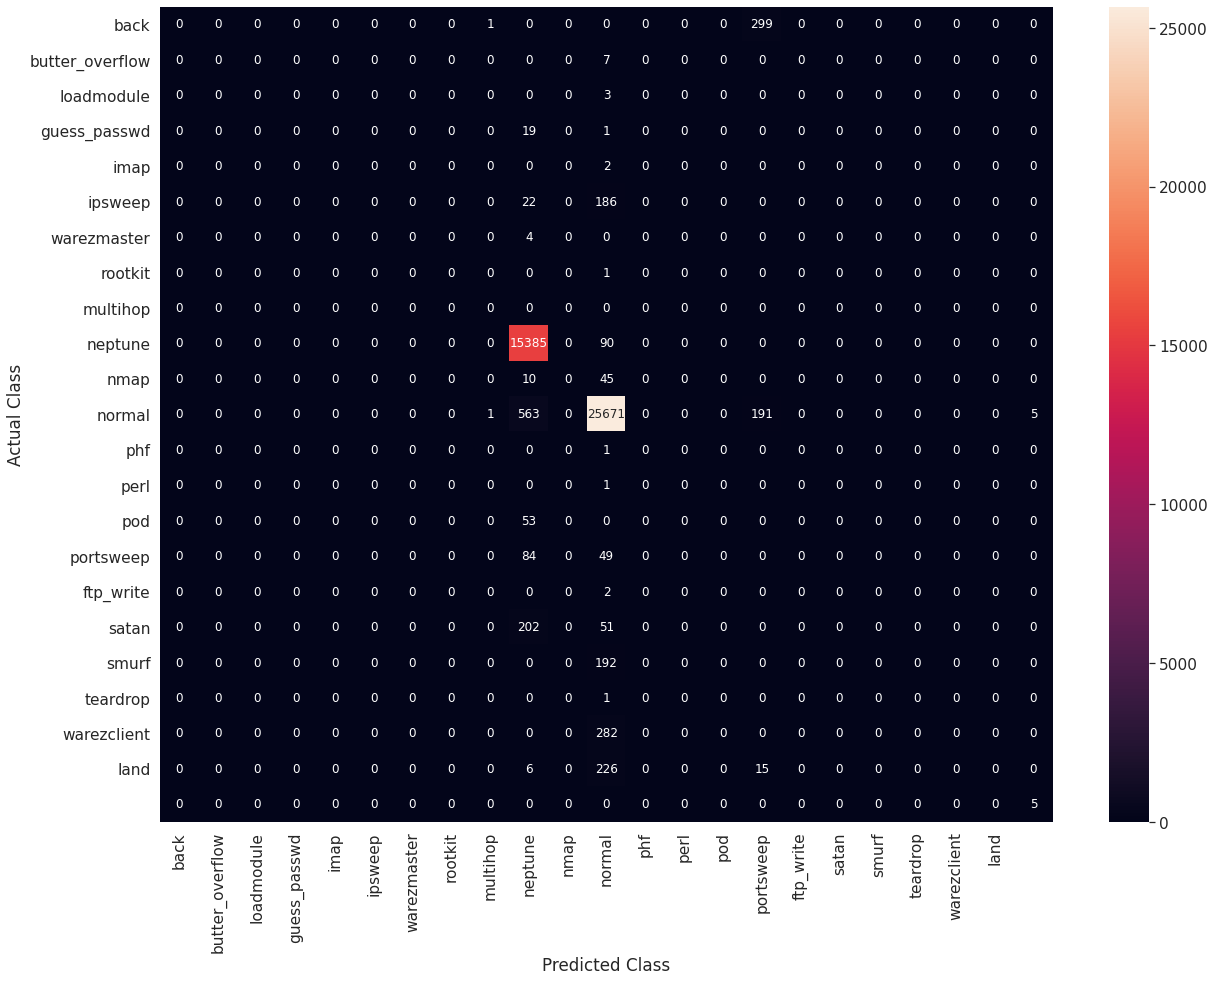

/root/Projects/Python/AdaptiveSIEMAlerting/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Precision score is:
0.9129289023010582


/root/Projects/Python/AdaptiveSIEMAlerting/venv/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Recall score is:
0.9401273010348933
F1-score is:
0.9262308169993282


In [51]:
lr_grid_results_tr, lr_grid_results_test = model(lr_grid, X_train_1, y_train, X_test_1, y_test)

#### Observation

- From the performance of the Logistic Regression model, we can conclude that the data has some linearity in the higher dimensional space which was not visible in the lower dimensional 2D pair plots and Tsne transformed 2D space.


- As the train and test scores are almost similar and high, we can say that the LR model is "NEITHER OVERFITTING NOR UNDERFITTING".

In [52]:
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers import Dropout
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D
from keras.utils import to_categorical
from sklearn.model_selection import train_test_split
from numpy import mean
from numpy import std

In [53]:
X.shape

(145586, 121)

In [54]:
from sklearn import decomposition

In [55]:
pca = decomposition.PCA(n_components=7)
pca.fit(X)
X = pca.transform(X)

In [56]:
X.shape

(145586, 7)

#### Reshaping Data  Dimensionality.

In [57]:
X = X.reshape(X.shape[0], X.shape[1], 1)

In [58]:
X.shape

(145586, 7, 1)

In [59]:
from keras.utils import to_categorical

from sklearn.preprocessing import LabelEncoder

encoder = LabelEncoder()
encoder.fit(Y)
encoded_Y = encoder.transform(Y)
y = to_categorical(encoded_Y)

In [60]:
y.shape

(145586, 23)

### Split Data into Training and Test

In [61]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [62]:
print(X_train.shape, y_train.shape, X_test.shape, y_test.shape)

(101910, 7, 1) (101910, 23) (43676, 7, 1) (43676, 23)


#### Define Neural Network

In [63]:
# fit and evaluate a model
def evaluate_model(model, trainX, trainy, testX, testy):
    verbose, epochs, batch_size = 0, 10, 32
    # fit network
    model.fit(trainX, trainy, epochs=epochs, batch_size=batch_size, verbose=verbose)
    # model save
    model.save("nid_siem_model.h5")
    # evaluate model
    _, accuracy = model.evaluate(testX, testy, batch_size=batch_size, verbose=0)
    return accuracy

In [64]:
def cnn_model(trainX, trainy, testX, testy):
    n_timesteps, n_features, n_outputs = trainX.shape[1], trainX.shape[2], trainy.shape[1]
    print("Features", n_features)
    print("Steps", n_timesteps)
    print("Outputs", n_outputs)
    model = Sequential()
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu', input_shape=(n_timesteps, n_features)))
    model.add(Conv1D(filters=64, kernel_size=3, activation='relu'))
    model.add(Dropout(0.5))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs, activation='softmax'))
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    model.summary()
    
    return model

In [65]:
# summarize scores
def summarize_results(scores):
    print(scores)
    m, s = mean(scores), std(scores)
    print('Accuracy: %.3f%% (+/-%.3f)' % (m, s))


# run an experiment
def run_experiment(repeats=1):
    # load data
    trainX, trainy, testX, testy = X_train, y_train, X_test, y_test
    # repeat experiment
    scores = list()
    model = cnn_model(trainX, trainy, testX, testy)
    for r in range(repeats):
        score = evaluate_model(model, trainX, trainy, testX, testy)
        score = score * 100.0
        print('>#%d: %.3f' % (r + 1, score))
        scores.append(score)
    # summarize results
    summarize_results(scores)


# run the experiment
run_experiment()

Features 1
Steps 7
Outputs 23
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d (Conv1D)              (None, 5, 64)             256       
_________________________________________________________________
conv1d_1 (Conv1D)            (None, 3, 64)             12352     
_________________________________________________________________
dropout (Dropout)            (None, 3, 64)             0         
_________________________________________________________________
max_pooling1d (MaxPooling1D) (None, 1, 64)             0         
_________________________________________________________________
flatten (Flatten)            (None, 64)                0         
_________________________________________________________________
dense (Dense)                (None, 100)               6500      
_________________________________________________________________
dense_1 (Dense)           

In [66]:
from sklearn.metrics import classification_report, confusion_matrix
from tensorflow.keras.models import load_model


model = load_model("nid_siem_model.h5", compile = True)
Y_prediction = model.predict(X_test, verbose=0)

In [67]:
def _confusion_matrix(Y_test, y_test_pred):
    '''
    This function plots the confusion matrix heatmap using the actual and predicted values.
    '''
    matrix = confusion_matrix(y_test.argmax(axis=1), Y_prediction.argmax(axis=1))
  
    plt.figure(figsize=(20,15))
    sns.set(font_scale=1.4)
    sns.heatmap(matrix, annot=True, annot_kws={"size":12}, fmt='g', xticklabels=labels, yticklabels=labels)
    plt.ylabel('Actual Class')
    plt.xlabel('Predicted Class')
    
    plt.show()

#### Confusion Matrice for Convolutionary Neural Network

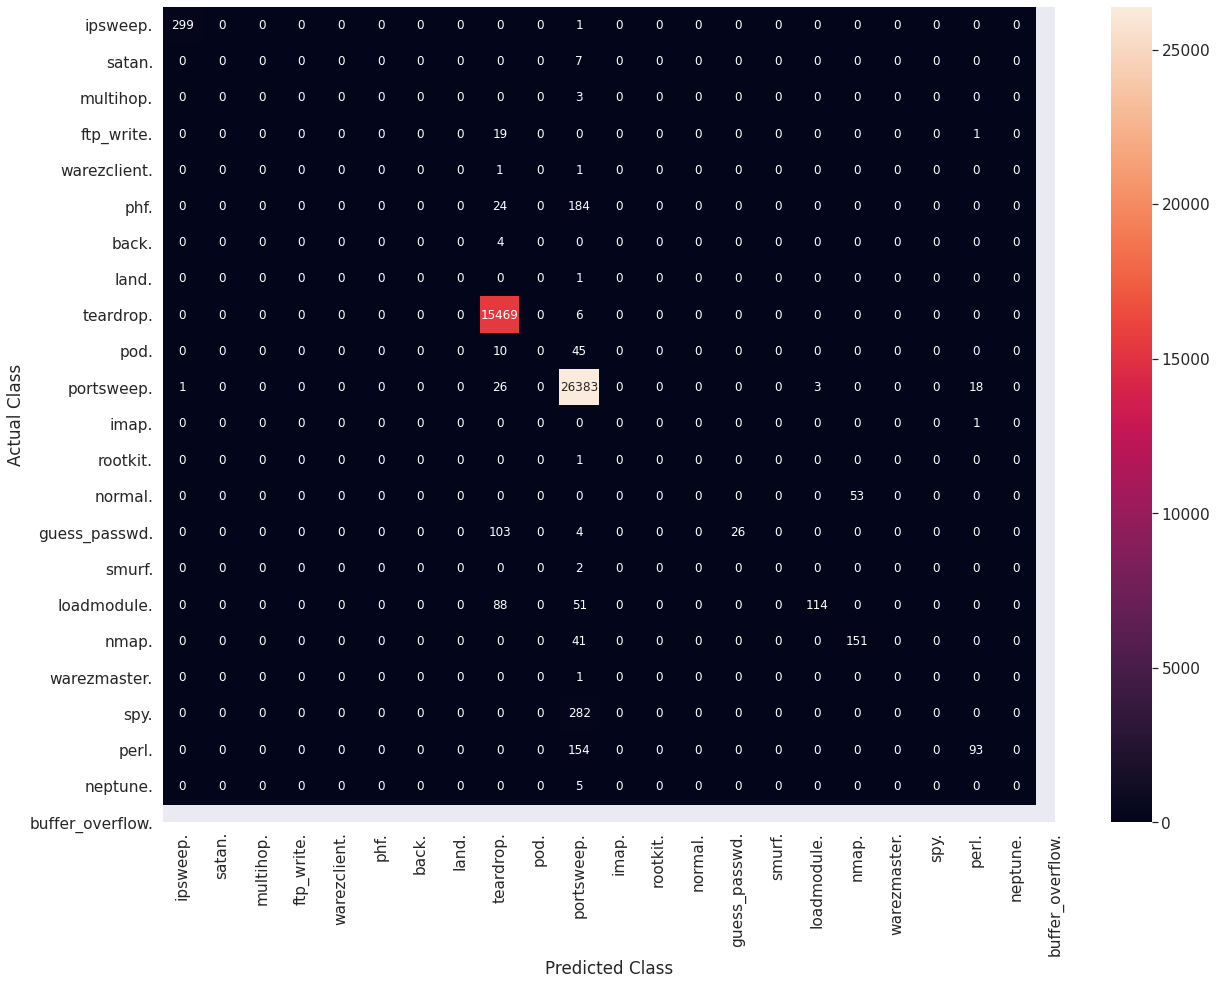

In [68]:
_confusion_matrix(y_test, Y_prediction)

In [108]:
import pandas as pd
import random

filename = '../datastore/kddcup.data_demo.csv'
n = sum(1 for line in open(filename)) - 1 #number of records in file (excludes header)
s = 1000 #desired sample size
skip = sorted(random.sample(range(1,n+1),n-s)) #the 0-indexed header will not be included in the skip list
data = pd.read_csv(filename, skiprows=skip)

In [109]:
data.head()

,duration,protocol_type,service,flag,src_bytes,dst_bytes,land,wrong_fragment,urgent,hot,...,dst_host_count,dst_host_srv_count,dst_host_same_srv_rate,dst_host_diff_srv_rate,dst_host_same_src_port_rate,dst_host_srv_diff_host_rate,dst_host_serror_rate,dst_host_srv_serror_rate,dst_host_rerror_rate,dst_host_srv_rerror_rate
0,0,tcp,http,SF,215,45076,0,0,0,0,...,0,0,0.0,0.0,0.00,0.0,0.0,0.0,0.0,0.0
1,0,tcp,http,SF,233,2032,0,0,0,0,...,15,15,1.0,0.0,0.07,0.0,0.0,0.0,0.0,0.0
2,0,tcp,http,SF,238,1282,0,0,0,0,...,16,16,1.0,0.0,0.06,0.0,0.0,0.0,0.0,0.0
3,0,tcp,http,SF,215,45076,0,0,0,0,...,30,30,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0
4,0,tcp,http,SF,218,1364,0,0,0,0,...,38,38,1.0,0.0,0.03,0.0,0.0,0.0,0.0,0.0


In [110]:
# Y_samp = data['label'].values

# X_samp = data.drop('label', axis=1)
X_samp = data

In [111]:
X_samp.shape

(1000, 41)

In [112]:
one_hot_encoder(X_samp, categorical_features)

In [113]:
zscore_numeric_encoder(X_samp,non_categorical_features)

In [114]:
pca = decomposition.PCA(n_components=7)
pca.fit(X_samp)
X_samp = pca.transform(X_samp)

In [115]:
X_samp.shape

(1000, 7)

In [116]:
X_samp = X_samp.reshape(X_samp.shape[0], X_samp.shape[1], 1)

In [117]:
X_samp.shape

(1000, 7, 1)

In [118]:
Y_prediction = model.predict(X_samp, verbose=0)

In [119]:
Y_prediction

array([[0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        1.4368162e-30, 7.6090922e-26],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 1.7747504e-34],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00],
       [0.0000000e+00, 0.0000000e+00, 0.0000000e+00, ..., 0.0000000e+00,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [120]:
labels = (Y_prediction < 0.5).astype(np.int)
print(labels)

[[1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 ...
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]
 [1 1 1 ... 1 1 1]]


In [121]:
import numpy as np

Y_prediction= np.argmax(Y_prediction, axis=-1)

In [122]:
encoder.inverse_transform(Y_prediction)

array(['neptune', 'normal', 'normal', 'neptune', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'neptune', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'normal',
       'normal', 'normal', 'normal', 'normal', 'normal', 'n

In [123]:
X_samp

array([[[ 6.19853079e+03],
        [ 1.83789505e+00],
        [-2.09140934e+01],
        ...,
        [-4.13726355e-02],
        [ 5.60988730e-02],
        [-1.57845859e-01]],

       [[-5.35796002e+02],
        [-3.47423657e+00],
        [-2.00219664e+01],
        ...,
        [-3.60441883e-02],
        [ 1.30173253e-02],
        [-1.75170362e-01]],

       [[-6.53135999e+02],
        [-2.85332972e+00],
        [-1.98292044e+01],
        ...,
        [ 1.69134701e-01],
        [ 1.19595550e-02],
        [-2.09516678e-01]],

       ...,

       [[-7.34797498e+02],
        [-6.43634531e+00],
        [-1.03820363e+01],
        ...,
        [-6.56998722e-01],
        [-5.92711248e-02],
        [ 6.68045231e-01]],

       [[-7.35113579e+02],
        [-3.80206349e+00],
        [-9.93394774e+00],
        ...,
        [-5.23458517e-01],
        [-6.11333280e-02],
        [ 7.60480565e-01]],

       [[-7.35592510e+02],
        [ 4.44467726e+00],
        [-9.33775829e+00],
        ...,
        

In [124]:
df =X_samp.nonzero()

In [125]:
df

(array([  0,   0,   0, ..., 999, 999, 999]),
 array([0, 1, 2, ..., 4, 5, 6]),
 array([0, 0, 0, ..., 0, 0, 0]))

In [126]:
z,x,y = df

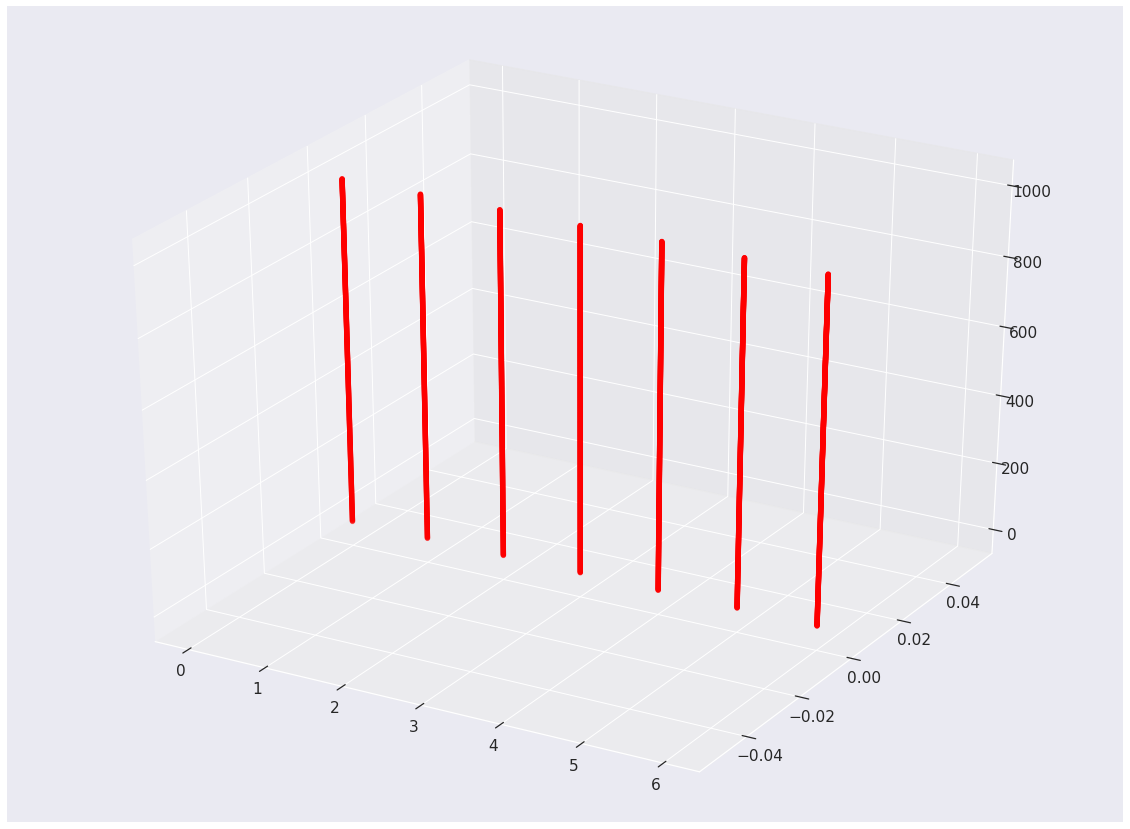

In [127]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
fig = plt.figure(figsize=(20,15))
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x, y, z, zdir='z', c= 'red')
plt.savefig("demo.png")

In [128]:
[X_samp[5]]

[array([[-6.53133510e+02],
        [-5.83283881e+00],
        [-1.55015056e+01],
        [ 2.72280932e+01],
        [ 5.06807900e-01],
        [ 1.02933561e-02],
        [-2.67038089e-01]])]

In [129]:
X_samp = X_samp[5]

In [130]:
X_samp = X_samp.reshape(1, X_samp.shape[0], X_samp.shape[1])

In [131]:
X_samp.shape

(1, 7, 1)

In [133]:
Y_pred = model.predict(X_samp, verbose=0)

In [134]:
Y_pred

array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
        0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

In [135]:
connection_type = (Y_pred < 0.5).astype(np.int)
print(connection_type)

[[1 1 1 1 1 1 1 1 1 1 1 0 1 1 1 1 1 1 1 1 1 1 1]]


In [136]:
import numpy as np

Y_pred= np.argmax(Y_pred, axis=-1)

In [137]:
encoder.inverse_transform(Y_pred)

array(['normal'], dtype=object)